# Slow Fast Moving Average

In [1]:
using Trading
using Trading.Strategies
using Trading.Basic
using Trading.Indicators
using Trading.Portfolio

struct SlowFast <: System end
Overseer.requested_components(::SlowFast) = (SMA{50, Close}, SMA{200, Close})

function Overseer.update(s::SlowFast, t::Trader, ticker_ledgers)
    for ticker_ledger in ticker_ledgers
        ticker = ticker_ledger.ticker
        for e in new_entities(ticker_ledger, s)
            prev_e = prev(e, 1)

            if prev_e === nothing
                continue
            end

            sma_50  = e[SMA{50, Close}].sma
            sma_200 = e[SMA{200, Close}].sma

            prev_sma_50 = prev_e[SMA{50, Close}].sma
            prev_sma_200 = prev_e[SMA{200, Close}].sma

            if sma_50 > sma_200 && prev_sma_50 < prev_sma_200
                Entity(t, Sale(ticker, 1.0))
            elseif sma_50 < sma_200 && prev_sma_50 > prev_sma_200
                Entity(t, Purchase(ticker, 1.0))
            end
        end
    end
end

The `Inf` values for the quantity of stocks to trade in the `Sale` and `Purchase` constructors signifies that we want to buy as many stocks as our cash balance allows for.

In [2]:
broker = HistoricalBroker(AlpacaBroker(ENV["ALPACA_KEY_ID"], ENV["ALPACA_SECRET"]))

strategy = Strategy(:slowfast, [SlowFast()], tickers=["MSFT", "AAPL"])

trader = BackTester(broker, start = DateTime("2015-01-01T00:00:00"),
                            stop = DateTime("2020-01-01T00:00:00"),
                            dt = Day(1),
                            strategies = [strategy],
                            cash = 1000,
                            only_day=false)
start(trader)

[ Info: Fetching historical data
⠋ Simulating... 	 Time: 0:00:01
  t:      2016-12-03T06:00:00
  value:  995.7733333333335[ Info: Closed Trading Stream
[ Info: Issue with data stream, restarting
✓ Simulating... 	 Time: 0:00:04


Trader

Main task:    Task (failed) @0x00007fb111d4e570
Trading task: Task (done) @0x00007fb111d4e290
Data task:    Task (done) @0x00007fb111d4e400

Portfolio -- positions: -451.34999999999997, cash: 1209.7231333333334, tot: 758.3731333333335

Current positions:
┌────────┬──────────┬─────────┐
│ Ticker │ Quantity │   Value │
├────────┼──────────┼─────────┤
│   MSFT │     -1.0 │  -157.7 │
│   AAPL │     -1.0 │ -293.65 │
└────────┴──────────┴─────────┘

Strategies:

Trades:
┌─────────────────────┬────────┬──────┬──────────┬───────────┬───────────┐
│                Time │ Ticker │ Side │ Quantity │ Avg Price │ Tot Price │
├─────────────────────┼────────┼──────┼──────────┼───────────┼───────────┤
│ 2019-04-10T06:00:00 │   AAPL │ sell │      1.0 │    198.68 │    198.68 │
│ 2019-03-06T06:00:00 │   MSFT │ sell │      1.0 │    111.87 │    111.87 │
│ 2018-12-19T06:00:00 │   MSFT │  buy │      1.0 │    103.65 │    103.65 │
│ 2018-11-29T06:00:00 │   AAPL │  buy │      1.0 │    182.66 │    182.66 

After having executed the strategy, we can see some quick overview from the output, but
by converting it to a `TimeArray` we can more easily analyse how the strategy performed

┌ Warning: Method to convert Trading.Order into TimeArray not implemented yet.
└ @ Trading ~/work/Trading.jl/Trading.jl/src/timearrays.jl:130
MethodError: no method matching merge(::TimeArray{Float64, 2, DateTime, Matrix{Float64}}, ::TimeArray{Any, 2, DateTime, Matrix{Any}}; method=:outer)
Closest candidates are:
  merge(::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, ::TimeArray, !Matched::Symbol; kw...) where T at deprecated.jl:70
  merge(::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, !Matched::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, !Matched::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, !Matched::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}...; colnames, kw...) where T at ~/.julia/packages/TimeSeries/kXlTD/src/combine.jl:79
  merge(::TimeArray{T, N, D, A} where A<:AbstractArray{T, N}, !Matched::TimeArray{T, M, D, A} where A<:AbstractArray{T, M}; method, col

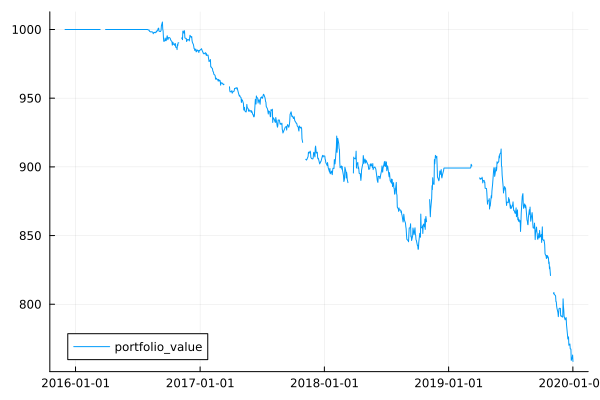

In [3]:
using Plots

ta = TimeArray(trader)

plot(ta[:portfolio_value])

We see that in this case the strategy didn't work particularly well. In fact it seems that
inverting it, we might get a better result.
We can simply redefine our `update` function as follows:

In [4]:
function Overseer.update(s::SlowFast, t::Trader, ticker_ledgers)
    for ticker_ledger in ticker_ledgers
        ticker = ticker_ledger.ticker
        for e in new_entities(ticker_ledger, s)
            prev_e = prev(e, 1)

            if prev_e === nothing
                continue
            end

            sma_50  = e[SMA{50, Close}].sma
            sma_200 = e[SMA{200, Close}].sma

            prev_sma_50 = prev_e[SMA{50, Close}].sma
            prev_sma_200 = prev_e[SMA{200, Close}].sma

            if sma_50 > sma_200 && prev_sma_50 < prev_sma_200
                Entity(t, Purchase(ticker, Inf))
            elseif sma_50 < sma_200 && prev_sma_50 > prev_sma_200
                Entity(t, Sale(ticker, Inf))
            end
        end
    end
end

We have basically swapped the `Purchase` and `Sale` components.
To execute this updated version we call `reset!` and `start` again.

In [5]:
reset!(trader)
start(trader)

[ Info: Closed Trading Stream
[ Info: Issue with data stream, restarting


Trader

Main task:    Task (failed) @0x00007fb0ed482290
Trading task: Task (done) @0x00007fb0ed481e40
Data task:    Task (done) @0x00007fb0ed481fb0

Portfolio -- positions: 2680.8999999999996, cash: -50.809999999999945, tot: 2630.0899999999997

Current positions:
┌────────┬──────────┬────────┐
│ Ticker │ Quantity │  Value │
├────────┼──────────┼────────┤
│   MSFT │     17.0 │ 2680.9 │
│   AAPL │      0.0 │    0.0 │
└────────┴──────────┴────────┘

Strategies:

Trades:
┌─────────────────────┬────────┬──────┬──────────┬───────────┬───────────┐
│                Time │ Ticker │ Side │ Quantity │ Avg Price │ Tot Price │
├─────────────────────┼────────┼──────┼──────────┼───────────┼───────────┤
│ 2019-04-10T06:00:00 │   AAPL │  buy │     -0.0 │    198.68 │      -0.0 │
│ 2019-03-06T06:00:00 │   MSFT │  buy │     17.0 │    111.87 │   1901.79 │
│ 2018-12-19T06:00:00 │   MSFT │ sell │     18.0 │    103.65 │    1865.7 │
│ 2018-05-10T06:00:00 │   AAPL │  buy │     -0.0 │    187.74 │      -0.0 │
│ 2

and plot the results again, this time taking the relative performances of the portfolio vs the two stocks:

┌ Warning: Method to convert Trading.Order into TimeArray not implemented yet.
└ @ Trading ~/work/Trading.jl/Trading.jl/src/timearrays.jl:130
MethodError: no method matching merge(::TimeArray{Float64, 2, DateTime, Matrix{Float64}}, ::TimeArray{Any, 2, DateTime, Matrix{Any}}; method=:outer)
Closest candidates are:
  merge(::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, ::TimeArray, !Matched::Symbol; kw...) where T at deprecated.jl:70
  merge(::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, !Matched::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, !Matched::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}, !Matched::TimeArray{T, N, D, A} where {N, D<:TimeType, A<:AbstractArray{T, N}}...; colnames, kw...) where T at ~/.julia/packages/TimeSeries/kXlTD/src/combine.jl:79
  merge(::TimeArray{T, N, D, A} where A<:AbstractArray{T, N}, !Matched::TimeArray{T, M, D, A} where A<:AbstractArray{T, M}; method, col

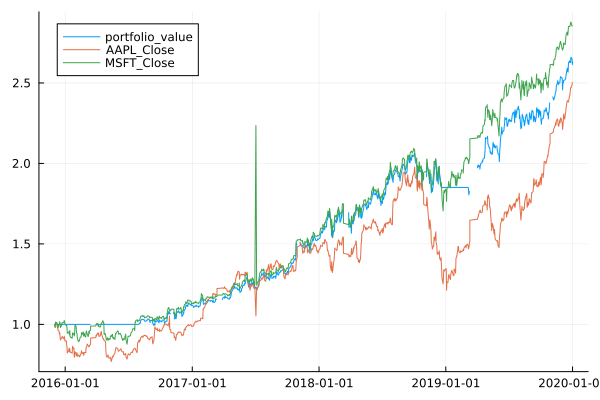

In [6]:
ta = Trading.relative(TimeArray(trader))

portfolio_val = ta[:portfolio_value]
aapl_closes = ta[:AAPL_Close]
msft_closes = ta[:MSFT_Close]

p = plot(merge(portfolio_val, aapl_closes, msft_closes))
savefig("slow_fast.svg") # hide
p # hide